This fits a simple MLP and then trains it while using auto-batching the loss computation over minibatches 
and the auto-batching the optimization over stepsizes, momentum constants, and initialization scales (all 
at once).

See `minimal_api_tutorial.ipynb` for a similar tutorial that only uses 3 Numbat functions.

In [2]:
# import stuff
import numbat as nb
import jax
from jax import numpy as jnp
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [3]:
# let's start by loading my favorite MNIST and convert into ntensor format
fmnist = fetch_openml(data_id=40996, as_frame=False, parser='liac-arff')

In [4]:
# convert the data into ntensor format
batch, height, width, cat, hidden, minibatch = nb.axes()
data   = jnp.reshape(fmnist["data"],[70000,28,28])/255.0
x      = nb.ntensor(data, batch, height, width)
y      = nb.ntensor(fmnist["target"].astype(int), batch)

In [5]:
print(x.shape)

{batch:70000, height:28, width:28}


In [6]:
print(y.shape)

{batch:70000}


In [7]:
def predict(params:dict[str,nb.ntensor], x:nb.ntensor)->nb.ntensor:
    "Given an ntensor for a SINGLE input and a parameter dictionary, compute a single output."
    assert x.axes == {width, height}
    assert params['w1'].axes == {width, height, hidden}
    assert params['b1'].axes == {hidden}
    assert params['w2'].axes == {hidden, cat}
    assert params['b2'].axes == {cat}
    
    H = nb.relu(params['w1'] @ x + params['b1'])
    out = params['w2'] @ H + params['b2']
    
    assert H.axes == {hidden}
    assert out.axes == {cat}
    return out

def logistic_loss(pred:nb.ntensor, y:nb.ntensor)->jnp.ndarray:
    "Given an ntensor of predictions and a SINGLE output, compute loss."
    assert pred.axes == {'cat'}
    assert y.axes == set()
    
    loss = nb.lift(jax.nn.logsumexp,'cat ->')(pred) - pred(cat=y)

    assert loss.axes == set()
    return loss

In [8]:
n_hidden = 128
params = dict()
params['w1'] = nb.randn(width=28,height=28,hidden=n_hidden)
params['b1'] = nb.randn(hidden=n_hidden)
params['w2'] = nb.randn(hidden=n_hidden, cat=10)
params['b2'] = nb.randn(cat=10)

predict(params, x(batch=5))

<ntensor {cat:10} [ -35.393433   -99.41312    223.17572   -177.35315    -77.997025
  102.31611     -6.2446866 -325.48627    -66.38293   -113.34158  ]>

In [9]:
# loss is Numbat scalar
logistic_loss(nb.ntensor(jnp.zeros(10), 'cat'), y(batch=0))

<ntensor {} 2.3025851>

In [10]:
def estimate_loss(params:dict[str,nb.ntensor], key:nb.ntensor)->jnp.ndarray:
    "Given dict of params and Jax PRNGKey, draw random input and output, make predictions, compute loss"
    b = nb.random_int(key, 0, 70000)
    my_x = x(batch=b)
    my_y = y(batch=b)
    pred = predict(params, my_x)
    return logistic_loss(pred, my_y)


#key = jax.random.PRNGKey(0)
key = nb.PRNGKey(0,'prngkey')
estimate_loss(params, key)



<ntensor {} 181.05463>

In [11]:
def estimate_loss_batched(params:dict[str,nb.ntensor], key:nb.ntensor)->jnp.ndarray:
    """Given dict of params and (ntensor) prngkey, draw a BUNCH of inputs, estimate all losses, take mean."""
    keys = nb.random_split(key, 128, 'minibatch')
    losses = nb.vmap(estimate_loss, {'minibatch'})(params, keys)
    return nb.mean(losses)

estimate_loss_batched(params, key)

<ntensor {} 206.69455>

In [12]:
g = nb.grad(estimate_loss_batched)(params, key)
{key: g[key].shape for key in g}

{'b1': ShapeDict(hidden=128),
 'b2': ShapeDict(cat=10),
 'w1': ShapeDict(width=28, height=28, hidden=128),
 'w2': ShapeDict(hidden=128, cat=10)}

In [13]:
def sgd(params:dict[str,nb.ntensor], step, momentum, scale):
    key = nb.PRNGKey(0,'prngkey')
    avg_loss = 0
    grad_fun = nb.value_and_grad(estimate_loss_batched)
    avg_g = {name:params[name]*0 for name in params}
    params = {name:params[name]*scale for name in params}
    
    def next(i, key, params, avg_loss, avg_g):
        key, subkey = nb.random_split(key)
        loss, g = grad_fun(params, subkey)
        beta = nb.maximum(momentum, 1/(1+i))
        avg_g = {name: (1-beta)*avg_g[name] + beta*g[name] for name in params}
        params = {name:params[name] - step*(avg_g[name]) for name in params}        
        alpha = nb.maximum(.05, 1/(i+1))
        avg_loss = (1-alpha)*avg_loss + alpha*loss
        return key, params, avg_loss, avg_g
    
    next = jax.jit(next)
    
    for i in range(100):
        key, params, avg_loss, avg_g = next(i, key, params, avg_loss, avg_g)
    return params, avg_loss

optimized_params, avg_loss = sgd(params, .01, .1, 1)
avg_loss

<ntensor {} 20.478714>

In [34]:
steps = nb.ntensor(2.0**-jnp.arange(0.5, 7, 0.5), 'step')
moms  = nb.ntensor(2.0**-jnp.arange(0, 8, 2), 'mom')
scales = nb.ntensor(2.0**-jnp.arange(0, 24, 4),'scale')
print(f"{steps=}")
print(f"{moms=}")
print(f"{scales=}")

steps=<ntensor {step:13} [0.70710677 0.5        0.35355338 0.25       0.17677669 0.125
 0.08838835 0.0625     0.04419417 0.03125    0.02209709 0.015625
 0.01104854]>
moms=<ntensor {mom:4} [1.       0.25     0.0625   0.015625]>
scales=<ntensor {scale:6} [1.0000000e+00 6.2500000e-02 3.9062500e-03 2.4414062e-04 1.5258789e-05
 9.5367432e-07]>


In [35]:
# batch across all steps sizes and all momentums AND initialization scales
_, avg_loss = nb.vmap(sgd, in_axes={'step','mom','scale'})(params, steps, moms, scales)

In [36]:
# convert to dataframe for easy plotting
df = nb.dataframe(avg_loss, 'loss', steps, moms, scales)

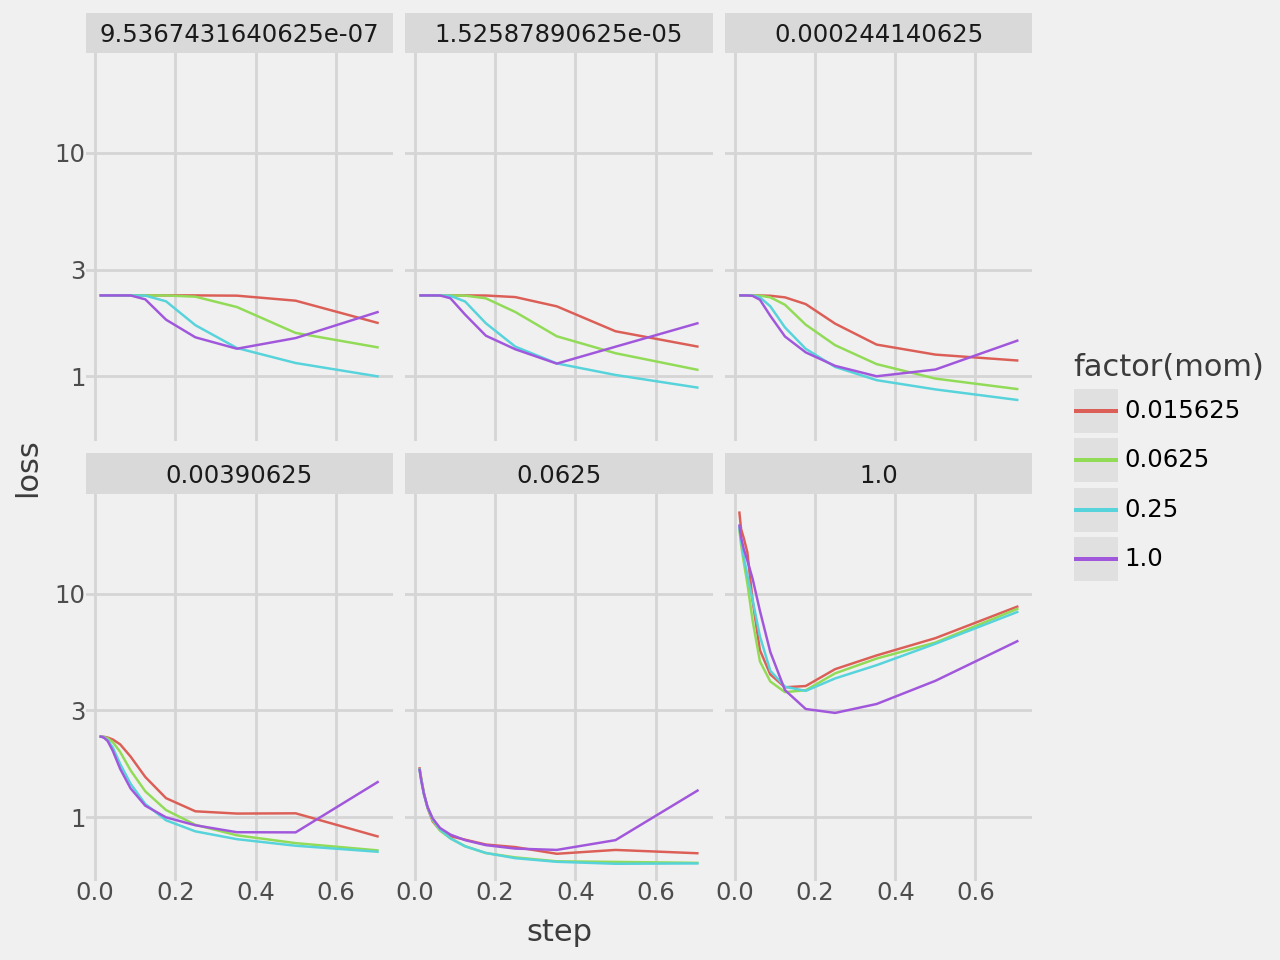

In [37]:
import plotnine as p9

(
        p9.ggplot(df, p9.aes('step', 'loss', color='factor(mom)'))
        + p9.geom_line()
        + p9.theme_538()
        + p9.facet_wrap('scale')
        + p9.labs()
        + p9.scale_y_log10()
 )